In [1]:
#import os
#os.chdir(r'C:\Users\Admin\Documents\Programming for Data Science\Coursework')
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import sqlite3
from matplotlib.patches import Patch

In [101]:
# Note: Insert your database name - e.g., 'airline_python.db'
conn = sqlite3.connect('airline2.db')
#OperationalError: Could not decode to UTF-8 column 'TailNum' with text '-N600�'--use this for ignoring invalid characters or
#alternatively use the code below to change to latin1 instead
#conn.text_factory= lambda x: x.decode('utf-8', 'ignore')
conn.text_factory = lambda x: str(x, 'latin1')

In [4]:
airports = pd.read_csv("airports.csv")
carriers = pd.read_csv("carriers.csv")
planes = pd.read_csv("plane-data.csv")

airports.to_sql('airports', con = conn, index = False)
carriers.to_sql('carriers', con = conn, index = False)
planes.to_sql('planes', con = conn, index = False)

5029

In [5]:
c = conn.cursor()

In [6]:
# To create ontime columns
c.execute('''
CREATE TABLE ontime (
  Year int,
  Month int,
  DayofMonth int,
  DayOfWeek int,
  DepTime  int,
  CRSDepTime int,
  ArrTime int,
  CRSArrTime int,
  UniqueCarrier varchar(5),
  FlightNum int,
  TailNum varchar(8),
  ActualElapsedTime int,
  CRSElapsedTime int,
  AirTime int,
  ArrDelay int,
  DepDelay int,
  Origin varchar(3),
  Dest varchar(3),
  Distance int,
  TaxiIn int,
  TaxiOut int,
  Cancelled int,
  CancellationCode varchar(1),
  Diverted varchar(1),
  CarrierDelay int,
  WeatherDelay int,
  NASDelay int,
  SecurityDelay int,
  LateAircraftDelay int
)
''')

conn.commit()

In [7]:
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
print(tables)

       name
0  airports
1  carriers
2    planes
3    ontime


In [8]:
# Load from csv.bz2 files

# Reading a compressed bz2 file directly is possible by adding "compression='bz2'" argument (see example below)
# x = pd.read_csv("2000.csv.bz2", compression='bz2')

# Alternatively, you could decompress bz2 files into csv then load

for year in range(2001, 2006):
    filename = str(year)+".csv.bz2"
    print('Processing:', filename)
    #ontime = pd.read_csv(filename, compression='bz2') #UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe4 in position 343: invalid continuation byte
    #ontime = pd.read_csv(filename, encoding="latin-1", compression='bz2') #avoids UnicodeDecodeError
    ontime = pd.read_csv(filename, encoding="latin-1", low_memory=False, compression='bz2') #avoids UnicodeDecodeError and mixed data type warning for column 22
    ontime.to_sql('ontime', con = conn, if_exists = 'append', index = False)

conn.commit()

Processing: 2001.csv.bz2
Processing: 2002.csv.bz2
Processing: 2003.csv.bz2
Processing: 2004.csv.bz2
Processing: 2005.csv.bz2


Question 2a) Find the best times, day of the week that minimises delays for each year

In [9]:
query = pd.read_sql_query(
    """
    SELECT Year, Month, DayofMonth AS Days, CRSDepTime AS DepartureTime, 
           DepDelay AS DepartureDelay
    FROM ontime
    WHERE Cancelled = 0 AND Diverted = 0
    """, conn)

In [29]:
def time_intervals(df, interval=1):
    if interval not in [1, 3]:
        raise ValueError("Please choose either 1 or 3 for intervals in hours or add another interval")
    
    # Hour breaks: 0, 1, 2, ..., 24
    hr_breaks = np.arange(0, 25, interval)
    
    # Zero-pad hours so that 0 -> 00, 1 -> 01, etc.
    labs = [f"{hr:02d}:00-{(hr + interval - 1):02d}:59" for hr in hr_breaks[:-1]]
    
    df = df.copy()
    # Extract hour and minute from DepartureTime (assumes HHMM format)
    df['hour'] = (df['DepartureTime'] // 100).astype(int)
    df['minute'] = (df['DepartureTime'] % 100).astype(int)

    # Fix cases where hour equals 24 (i.e. "2400" becomes "00:00")
    df.loc[df['hour'] == 24, 'hour'] = 0
    
    # Build a date column using Year, Month, and Days (ensure column names match your data)
    df['date'] = pd.to_datetime(
        df['Year'].astype(str) + '-' +
        df['Month'].astype(str).str.zfill(2) + '-' +
        df['Days'].astype(str).str.zfill(2),
        format='%Y-%m-%d',
        errors='coerce'
    )
    
    # Create a time string with zero-padded hour and minute
    time_str = df['hour'].astype(str).str.zfill(2) + ':' + df['minute'].astype(str).str.zfill(2)
    
    # Combine the date and time string to form a full datetime
    df['time_act'] = pd.to_datetime(
        df['date'].dt.strftime('%Y-%m-%d') + ' ' + time_str,
        format='%Y-%m-%d %H:%M',
        errors='coerce'
    )
    
    # Bin the hour into time intervals and create an ordered categorical variable.
    df['timeframe'] = pd.cut(
        df['hour'],
        bins=hr_breaks,
        labels=labs,
        right=False,
        include_lowest=True
    )
    df['timeframe'] = pd.Categorical(df['timeframe'], categories=labs, ordered=True)
    
    # Optionally drop the temporary hour and minute columns
    df.drop(columns=['hour', 'minute'], inplace=True)
    return df

# Apply the function (assuming 'query' is your original DataFrame)
onehrtime = time_intervals(query, interval=1)
print(onehrtime.head())

   Year  Month  Days  DepartureTime  DepartureDelay       date  \
0  2001      1    17           1810              -4 2001-01-17   
1  2001      1    18           1810              -5 2001-01-18   
2  2001      1    19           1810              11 2001-01-19   
3  2001      1    20           1810              -3 2001-01-20   
4  2001      1    21           1810               0 2001-01-21   

             time_act    timeframe  
0 2001-01-17 18:10:00  18:00-18:59  
1 2001-01-18 18:10:00  18:00-18:59  
2 2001-01-19 18:10:00  18:00-18:59  
3 2001-01-20 18:10:00  18:00-18:59  
4 2001-01-21 18:10:00  18:00-18:59  


In [30]:
def ontime_delay(df):
    """
    This function computes an OnTime indicator (1 if DepartureDelay is between -15 and 15, else 0),
    groups the data by Year and timeframe, and calculates the average on-time rate.
    """
    df = df.copy()
    df['OnTime'] = np.where((df['DepartureDelay'] >= -15) & (df['DepartureDelay'] <= 15), 1, 0)
    # Group by Year and timeframe and calculate the mean OnTime rate
    grouped = df.groupby(['Year', 'timeframe'], as_index=False)['OnTime'].mean().rename(columns={'OnTime': 'OnTimeRate'})
    # Sort by Year and OnTimeRate (ascending order as in the R arrange)
    grouped = grouped.sort_values(by=['Year', 'OnTimeRate'])
    return grouped

ontime_data = ontime_delay(onehrtime)

# Filter data for the years 2001 to 2005 and mark the maximum on-time rate in each year
yearly_data = ontime_data[ontime_data['Year'].isin(range(2001, 2006))].copy()
yearly_data['is_max'] = yearly_data.groupby('Year')['OnTimeRate'].transform(lambda x: x == x.max())
yearly_data['Year'] = yearly_data['Year'].astype('category')

def Ontime_plot(select_year):
    data = yearly_data[yearly_data['Year'] == select_year].copy()
    
    # Sort the data by the categorical order
    data.sort_values(by='timeframe', key=lambda x: x.cat.codes, inplace=True)
    
    # Assign bar colors (red for is_max = True, green otherwise)
    colors = ['red' if flag else 'green' for flag in data['is_max']]
    
    plt.figure(figsize=(10, 6))
    # Plot using the ordered timeframe categories
    plt.bar(data['timeframe'], data['OnTimeRate'], color=colors)
    
    plt.xlabel("Time Interval")
    plt.ylabel("On-Time Rate")
    plt.title(f"On-Time Rate in 1-hour timeframe for {select_year}")
    plt.xticks(rotation=90, fontsize=10)
    
    # Create a custom legend
    red_patch = plt.Rectangle((0, 0), 1, 1, color='red')
    green_patch = plt.Rectangle((0, 0), 1, 1, color='green')
    plt.legend([red_patch, green_patch], ["Most On-Time", "Normal"], title="On-Time Status", loc='upper right')
    
    plt.tight_layout()
    plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_20384\1036100140.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['Year', 'timeframe'], as_index=False)['OnTime'].mean().rename(columns={'OnTime': 'OnTimeRate'})


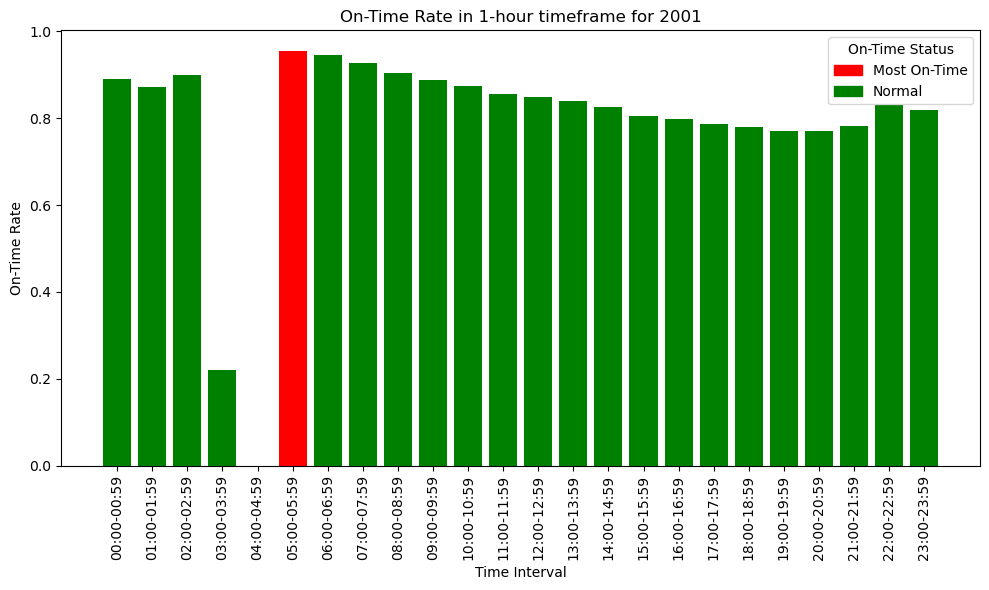

In [31]:
Ontime_plot(2001)

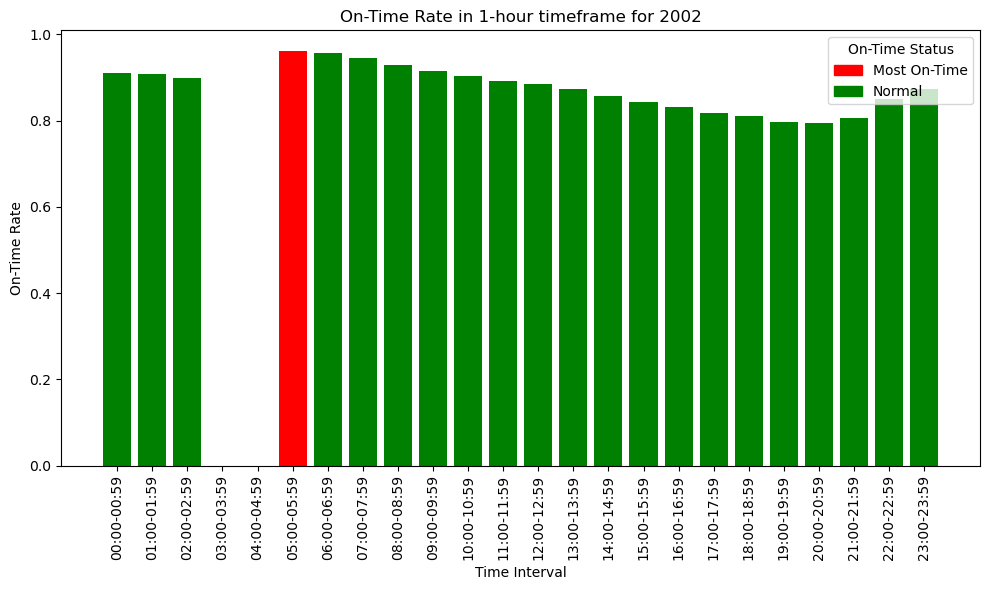

In [32]:
Ontime_plot(2002)

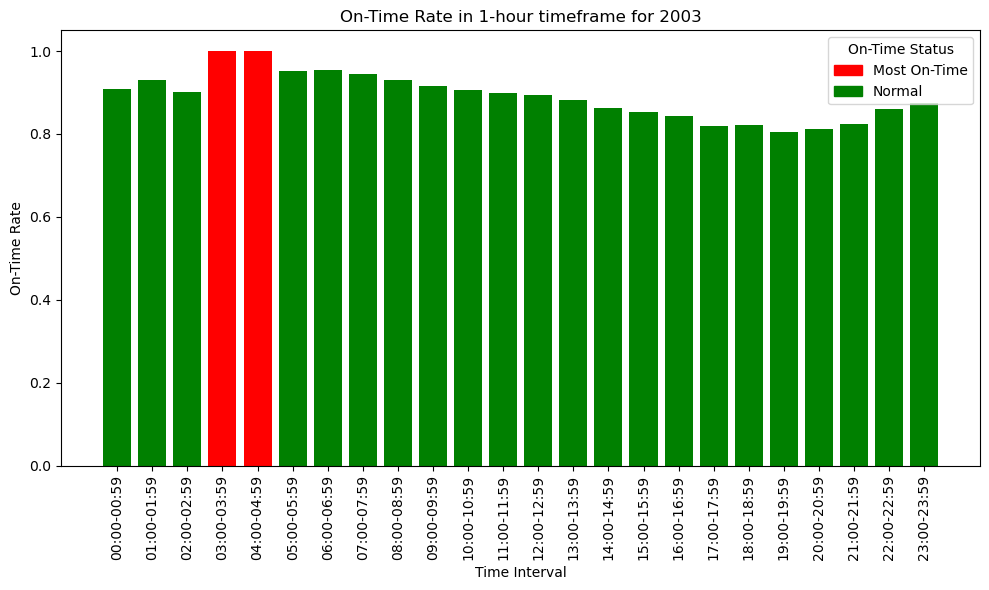

In [33]:
Ontime_plot(2003)

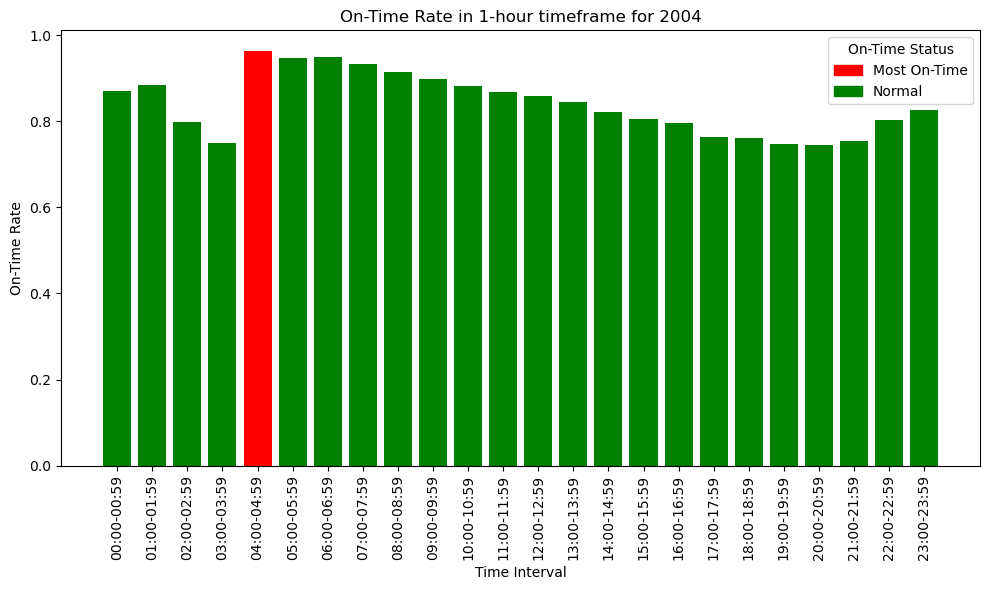

In [34]:
Ontime_plot(2004)

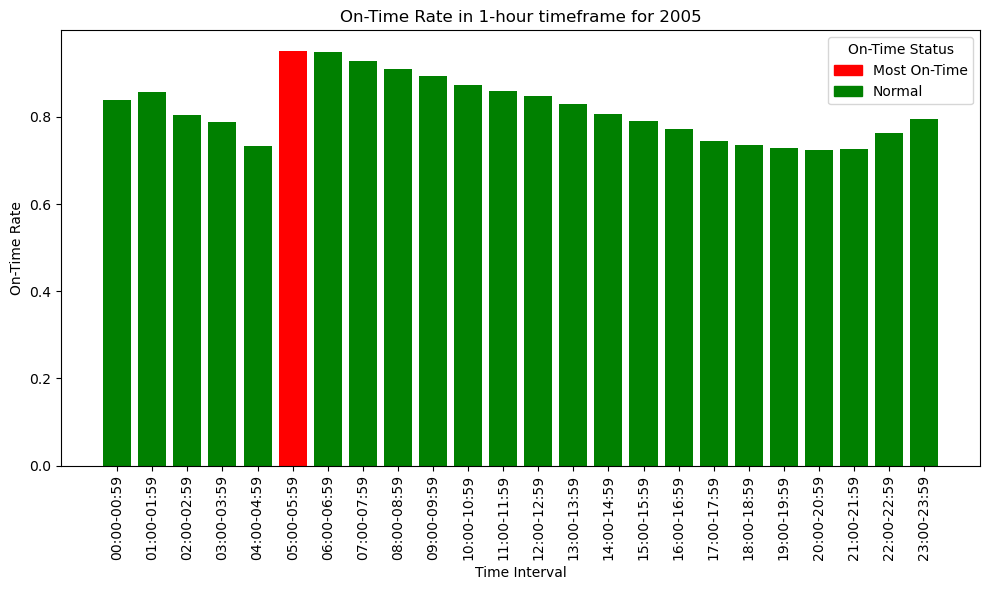

In [35]:
Ontime_plot(2005)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20384\1315214325.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  q_BD_grouped = q_BD_grouped.groupby('Year').apply(mark_min_day).reset_index(drop=True)


   Year  DayofWeek  AverageDelay  minday
5  2001    Tuesday      6.052606    True
6  2001  Wednesday      6.893079   False
1  2001     Monday      7.181753   False
2  2001   Saturday      7.737895   False
3  2001     Sunday      8.795183   False


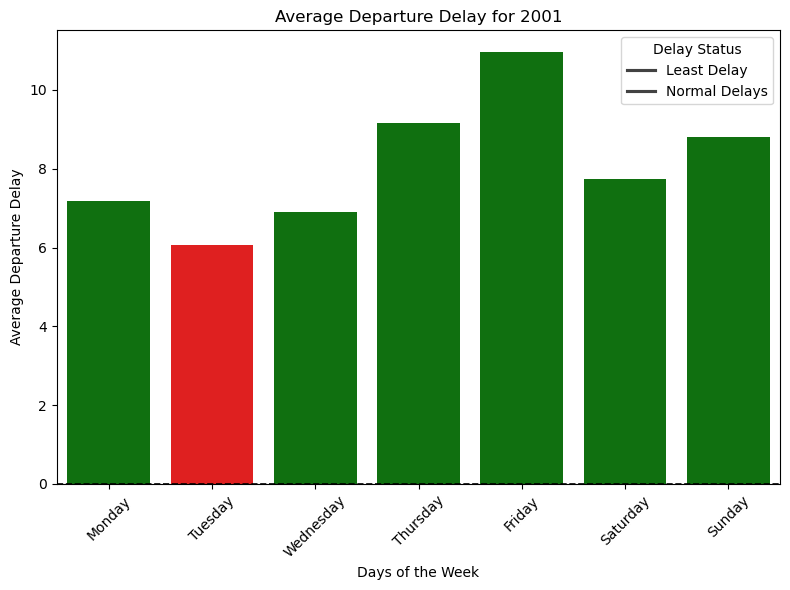

In [17]:
# Execute the query to get Year, DayOfWeek, and DepDelay (renamed as DepartureDelays)
q_BD = pd.read_sql_query(
    """
    SELECT Year, DayOfWeek, DepDelay AS DepartureDelays
    FROM ontime
    WHERE Cancelled = 0 AND Diverted = 0
    ORDER BY Year;
    """,
    conn
)

# Map DayOfWeek numeric values to day names
day_mapping = {1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 
               5: "Friday", 6: "Saturday", 7: "Sunday"}
q_BD['DayofWeek'] = q_BD['DayOfWeek'].map(day_mapping)
q_BD['Year'] = q_BD['Year'].astype(int)

# Group by Year and DayofWeek and compute the average delay.
# (You could use median if you prefer; change 'mean' to 'median' if needed.)
q_BD_grouped = q_BD.groupby(['Year', 'DayofWeek'], as_index=False)['DepartureDelays'].mean()
q_BD_grouped = q_BD_grouped.rename(columns={'DepartureDelays': 'AverageDelay'})

# For each year, mark the day with the minimum absolute average delay.
def mark_min_day(df):
    min_val = df['AverageDelay'].abs().min()
    df['minday'] = df['AverageDelay'].abs() == min_val
    return df

q_BD_grouped = q_BD_grouped.groupby('Year').apply(mark_min_day).reset_index(drop=True)

# Sort the results for clarity (optional)
q_BD_grouped = q_BD_grouped.sort_values(['Year', 'AverageDelay'])
print(q_BD_grouped.head())

# Define a function to plot the average delay by day for a selected year.
def Day_plot(selected_year):
    data = q_BD_grouped[q_BD_grouped['Year'] == selected_year].copy()
    
    # Define the desired order
    day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    
    # Convert DayofWeek to an ordered categorical
    data['DayofWeek'] = pd.Categorical(
        data['DayofWeek'],
        categories=day_order,
        ordered=True
    )
    
    # Sort by the categorical order 
    data.sort_values("DayofWeek", inplace=True)
    
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x='DayofWeek', 
        y='AverageDelay', 
        data=data, 
        hue='minday', 
        dodge=False,
        palette={True: 'red', False: 'green'}
    )
    plt.axhline(0, color='black', linestyle='dashed', linewidth=1.2)
    plt.title(f"Average Departure Delay for {selected_year}")
    plt.xlabel("Days of the Week")
    plt.ylabel("Average Departure Delay")
    plt.xticks(rotation=45, fontsize=10)
    plt.legend(title="Delay Status", labels=["Least Delay", "Normal Delays"])
    plt.tight_layout()
    plt.show()

# Example usage: Plot for year 2001
Day_plot(2001)

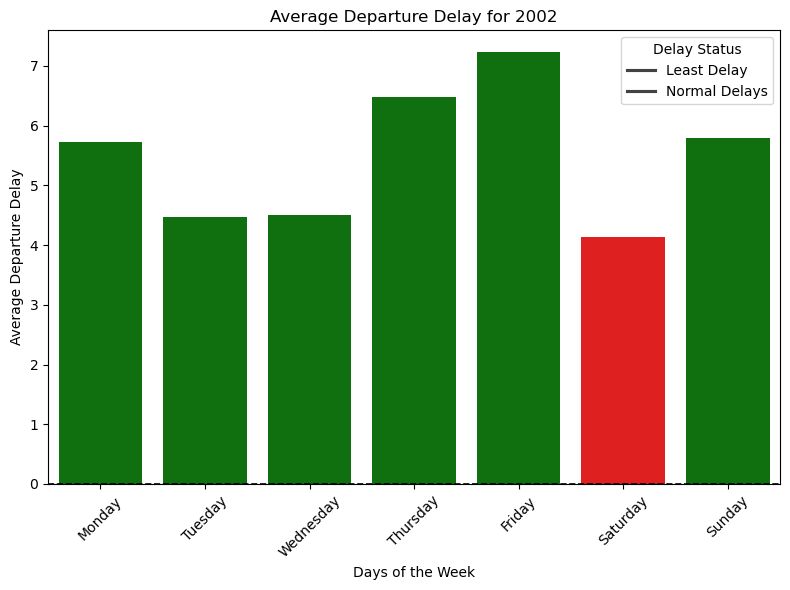

In [18]:
Day_plot(2002)

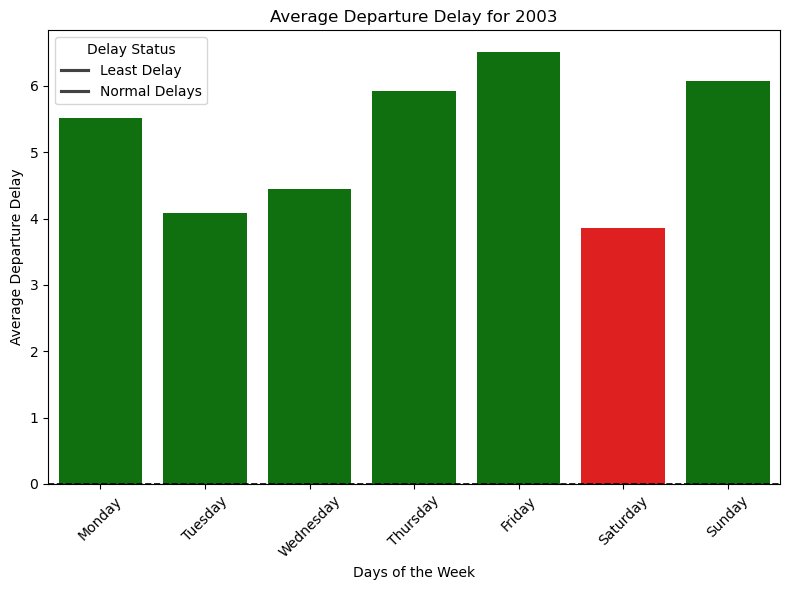

In [19]:
Day_plot(2003)

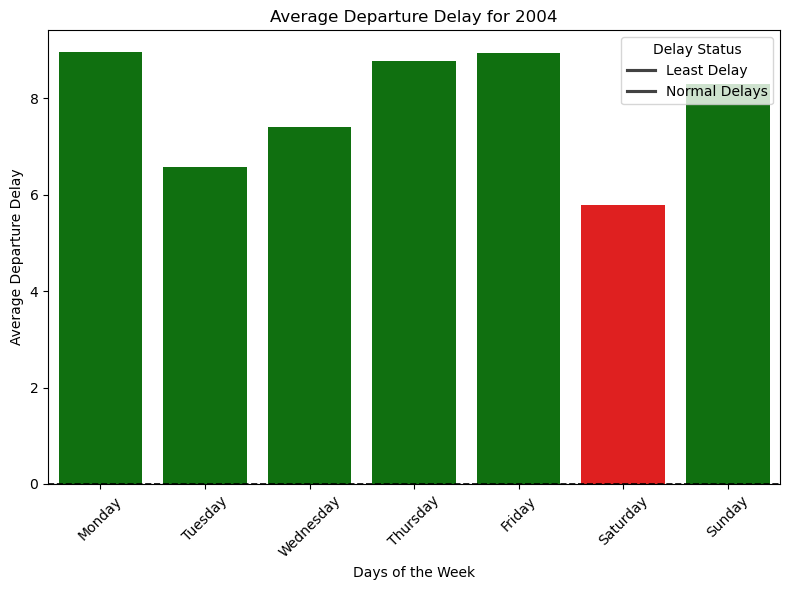

In [20]:
Day_plot(2004)

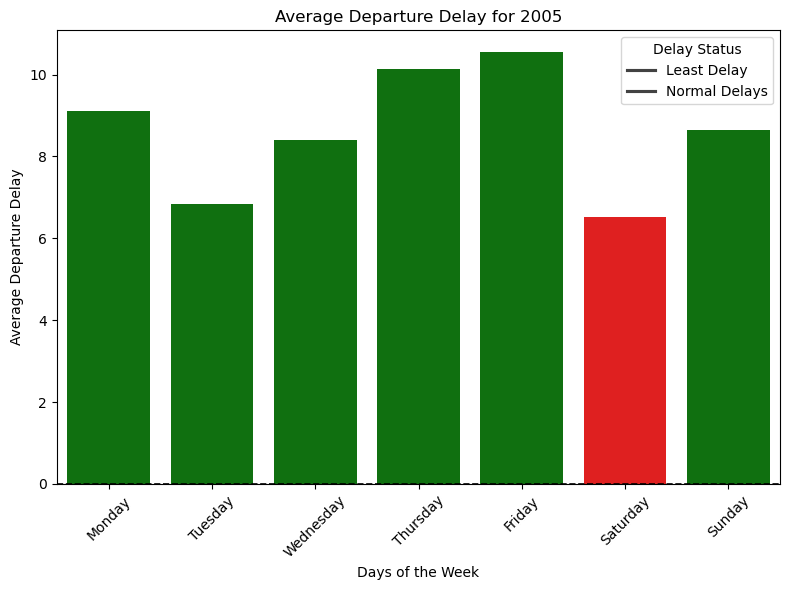

In [21]:
Day_plot(2005)

Question 2b) Does older planes suffer more delays

In [36]:
from scipy.stats import pearsonr, spearmanr, kendalltau
import statsmodels.api as sm

In [79]:
q3 = pd.read_sql_query(
    """
    SELECT ontime.Year AS Year, 
           planes.model AS PlaneModels, 
           ontime.DepDelay AS DepDelay, 
           planes.year AS PlaneIssuedYear
    FROM ontime
    JOIN planes ON ontime.tailnum = planes.tailnum
    WHERE ontime.Cancelled = 0 AND ontime.Diverted = 0
    """,
    conn
)

In [95]:
# Cleaning
q3 = q3[(q3['PlaneModels'].notna()) & (q3['PlaneIssuedYear'].notna()) &
        (q3['PlaneModels'] != ' ') & (q3['PlaneIssuedYear'] != ' ') &
        (q3['PlaneModels'] != 'None') & (q3['PlaneIssuedYear'] != 'None') &
        (q3['PlaneModels'] != '0000') & (q3['PlaneIssuedYear'] != '0000')]

# Convert to integers and calculate PlaneAge
q3['PlaneIssuedYear'] = q3['PlaneIssuedYear'].astype(int)
q3['PlaneAge'] = q3['Year'] - q3['PlaneIssuedYear']
q3 = q3[q3['PlaneAge'] >= 0]

In [96]:
q3['PlaneAge'] = np.where(q3['PlaneIssuedYear'] == 0, 0, q3['Year'] - q3['PlaneIssuedYear'])
q3 = q3[q3['PlaneAge'] >= 0]

In [97]:
# Summary
grouped = q3.groupby(['Year', 'PlaneAge']).agg(
    TotalDelays=('DepDelay', lambda x: x.dropna().sum()),
    FlightCount=('DepDelay', 'count')
).reset_index()
grouped['AveDelays'] = grouped['TotalDelays'] / grouped['FlightCount']

In [98]:
# Correlation analysis
unique_years = sorted(grouped['Year'].unique())
cor_list = []
for yr in unique_years:
    yr_data = grouped[grouped['Year'] == yr]
    pearson_corr, pearson_p = pearsonr(yr_data['AveDelays'], yr_data['PlaneAge'])
    spearman_corr, spearman_p = spearmanr(yr_data['AveDelays'], yr_data['PlaneAge'])
    kendall_corr, kendall_p = kendalltau(yr_data['AveDelays'], yr_data['PlaneAge'])

    cor_list.append({
        'FlightYear': yr,
        'Pearson_cor': pearson_corr,
        'Pearson_pval': pearson_p,
        'Spearman_cor': spearman_corr,
        'Spearman_pval': spearman_p,
        'Kendall_cor': kendall_corr,
        'Kendall_pval': kendall_p
    })

final_results = pd.DataFrame(cor_list).sort_values('FlightYear')
print(final_results)


   FlightYear  Pearson_cor  Pearson_pval  Spearman_cor  Spearman_pval  \
0        2001    -0.084654      0.783344      0.087912       0.775195   
1        2002     0.133494      0.405364     -0.000871       0.995687   
2        2003    -0.431024      0.003908     -0.545304       0.000156   
3        2004    -0.346992      0.019530     -0.241765       0.109596   
4        2005    -0.278904      0.060519     -0.229356       0.125208   

   Kendall_cor  Kendall_pval  
0     0.051282      0.857734  
1     0.053659      0.621161  
2    -0.364341      0.000575  
3    -0.147475      0.153229  
4    -0.145894      0.152806  


In [99]:
final_results_significance = final_results.assign(
    Pearson_Significant=final_results['Pearson_pval'] < 0.05,
    Spearman_Significant=final_results['Spearman_pval'] < 0.05,
    Kendall_Significant=final_results['Kendall_pval'] < 0.05
).drop(columns=['Pearson_pval', 'Spearman_pval', 'Kendall_pval'])

print(final_results_significance)

   FlightYear  Pearson_cor  Spearman_cor  Kendall_cor  Pearson_Significant  \
0        2001    -0.084654      0.087912     0.051282                False   
1        2002     0.133494     -0.000871     0.053659                False   
2        2003    -0.431024     -0.545304    -0.364341                 True   
3        2004    -0.346992     -0.241765    -0.147475                 True   
4        2005    -0.278904     -0.229356    -0.145894                False   

   Spearman_Significant  Kendall_Significant  
0                 False                False  
1                 False                False  
2                  True                 True  
3                 False                False  
4                 False                False  


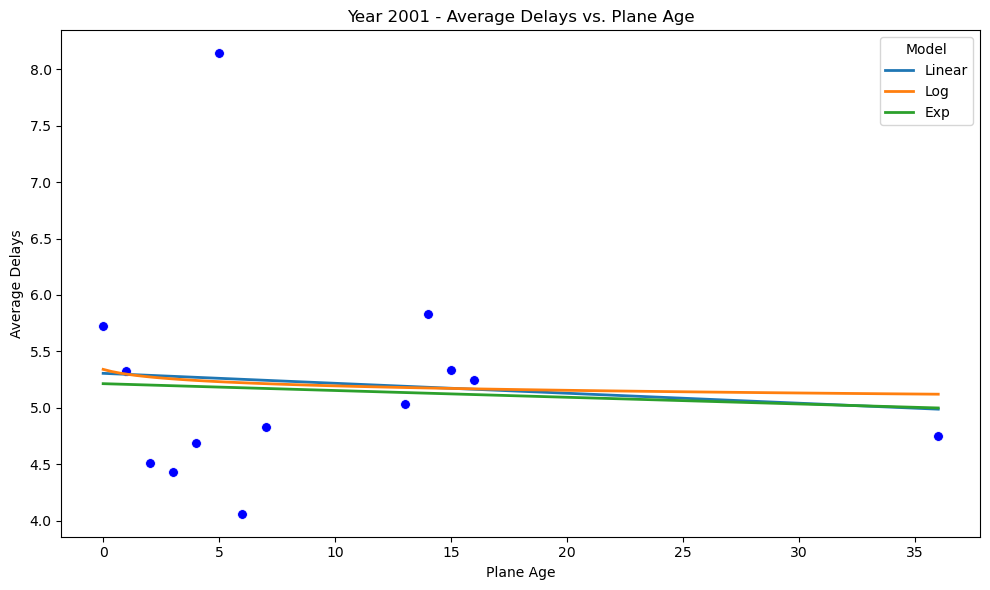

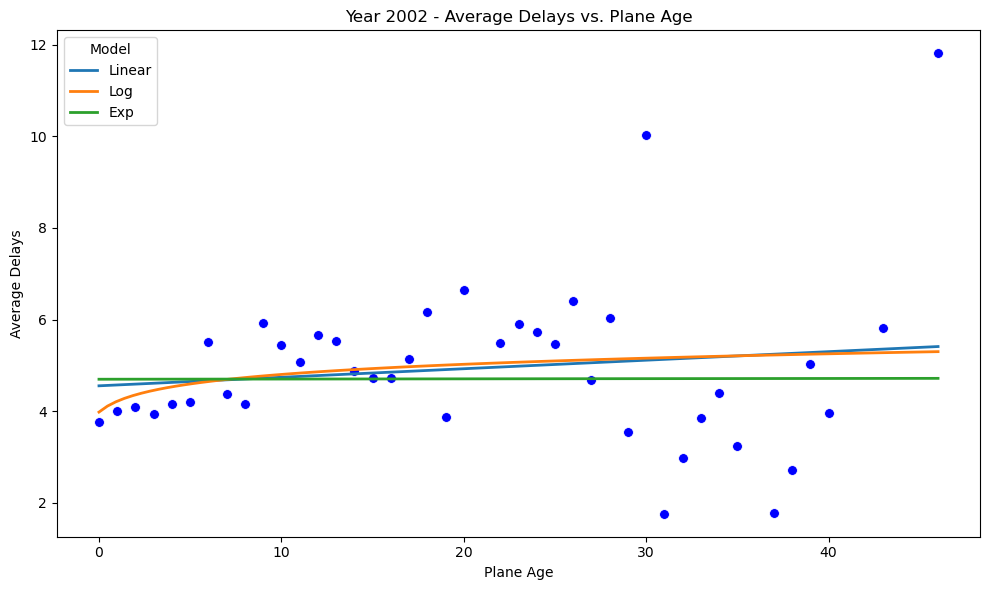

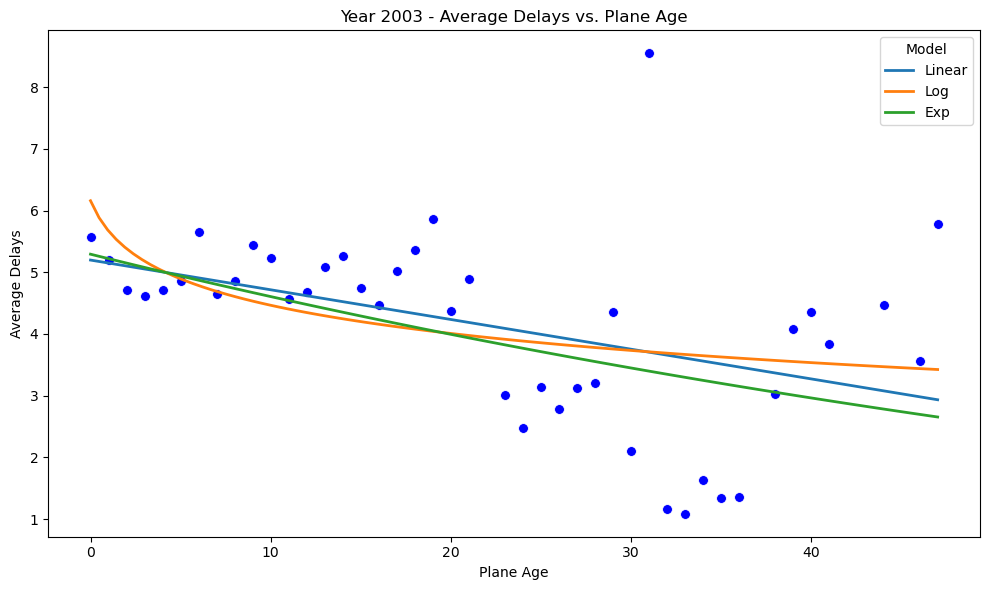

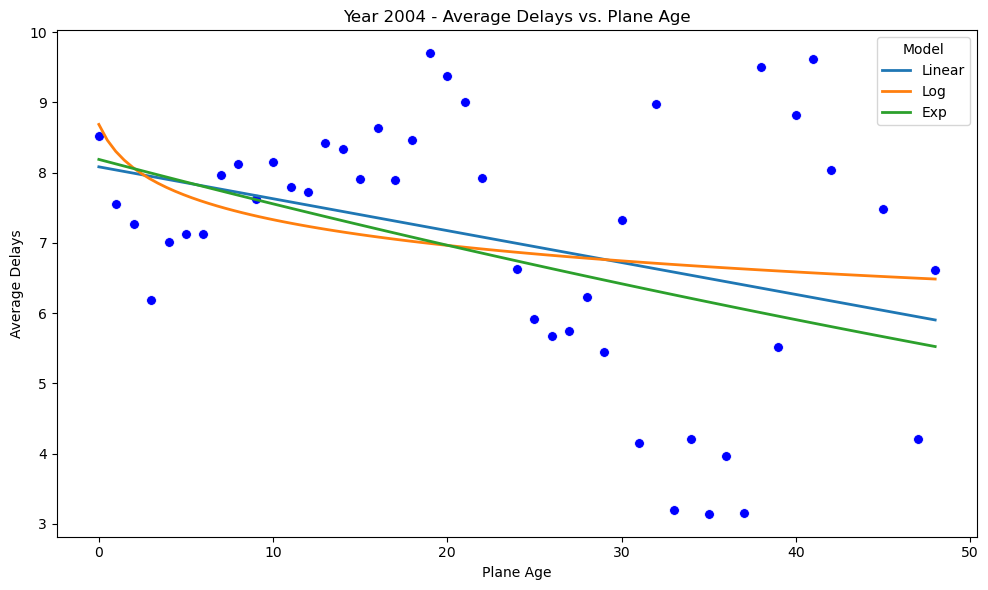

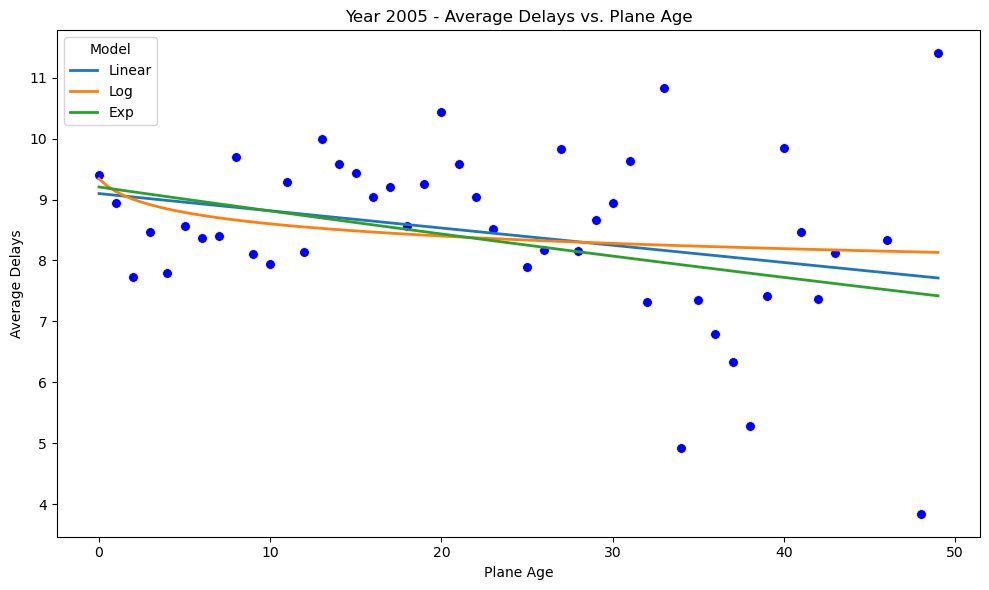

In [100]:
# Model fitting and plotting
for yr in unique_years:
    yr_data = grouped[grouped['Year'] == yr]
    X = yr_data['PlaneAge']
    Y = yr_data['AveDelays']

    X_linear = sm.add_constant(X)
    linear_model = sm.OLS(Y, X_linear).fit()

    log_model = sm.OLS(Y, sm.add_constant(np.log1p(X))).fit()
    exp_model = sm.OLS(np.log1p(Y), X_linear).fit()

    age_seq = np.linspace(X.min(), X.max(), 100)

    pred_linear = linear_model.predict(sm.add_constant(age_seq))
    pred_log = log_model.predict(sm.add_constant(np.log1p(age_seq)))
    pred_exp = np.expm1(exp_model.predict(sm.add_constant(age_seq)))

    plot_df = pd.DataFrame({
        'PlaneAge': np.tile(age_seq, 3),
        'AveDelays': np.concatenate([pred_linear, pred_log, pred_exp]),
        'Model': ['Linear'] * 100 + ['Log'] * 100 + ['Exp'] * 100
    })

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=yr_data, x='PlaneAge', y='AveDelays', color='blue', s=50)
    sns.lineplot(data=plot_df, x='PlaneAge', y='AveDelays', hue='Model', linewidth=2)
    plt.title(f"Year {yr} - Average Delays vs. Plane Age")
    plt.xlabel("Plane Age")
    plt.ylabel("Average Delays")
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()


In [43]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, roc_auc_score, fbeta_score,
    precision_score, recall_score, matthews_corrcoef,
    confusion_matrix, RocCurveDisplay
)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from pandas.api.types import CategoricalDtype

In [44]:
q = """
SELECT ontime.Year AS Year, 
       ontime.Month, 
       ontime.DayofMonth,
       ontime.CRSDepTime, 
       ontime.CRSArrTime, 
       airports.lat AS Latitude, 
       airports.long AS Longitude, 
       ontime.Diverted AS Diverted, 
       ontime.Distance AS Distance, 
       ontime.UniqueCarrier AS carrier
FROM ontime
INNER JOIN planes ON ontime.TailNum = planes.tailnum
INNER JOIN airports ON ontime.Origin = airports.iata
INNER JOIN carriers ON ontime.UniqueCarrier = carriers.Code
WHERE ontime.Cancelled = 0
"""
flights = pd.read_sql_query(q, conn)

In [45]:
# Create the Seasons variable by binning the Month.
# Breaks: 0, 2, 5, 8, 11, 12 with corresponding labels.
flights['Seasons'] = pd.cut(flights['Month'],
                            bins=[0, 2, 5, 8, 11, 12],
                            labels=["Winter", "Spring", "Summer", "Fall", "Winter_End"],
                            ordered=True,
                            right=True, include_lowest=True)

# Create the Period variable by binning DayOfMonth.
flights['Period'] = pd.cut(flights['DayofMonth'],
                           bins=[0, 10, 20, 31],
                           labels=["Early", "Mid", "Late"],
                           ordered=True,
                           include_lowest=True)

In [46]:
# Calculate HourDep and HourArr from CRSDepTime and CRSArrTime (assumed to be in HHMM format)
flights['HourDep'] = np.floor(flights['CRSDepTime'] / 100).astype(int)
flights['HourArr'] = np.floor(flights['CRSArrTime'] / 100).astype(int)

# Convert hours to radians (0 to 2π)
flights['HourDep_rad'] = (2 * np.pi * flights['HourDep']) / 24
flights['HourArr_rad'] = (2 * np.pi * flights['HourArr']) / 24

# Sine and Cosine transformations (to simulate a clock)
flights['HourDep_sin'] = np.sin(flights['HourDep_rad'])
flights['HourDep_cos'] = np.cos(flights['HourDep_rad'])
flights['HourArr_sin'] = np.sin(flights['HourArr_rad'])
flights['HourArr_cos'] = np.cos(flights['HourArr_rad'])

In [47]:
def run_flight_logistic_regression(flights, year, threshold=0.3):
    features = ['Seasons', 'Period', 'HourDep_sin', 'HourDep_cos', 'Latitude', 'Longitude', 'Distance']
    numerical_features = ['HourDep_sin', 'HourDep_cos', 'Latitude', 'Longitude', 'Distance']
    categorical_features = ['Seasons', 'Period']

    # Define category levels with desired reference for dummy encoding
    season_order = ['Fall', 'Winter', 'Spring', 'Summer', 'Winter_End']  # Fall = baseline
    period_order = ['Late', 'Early', 'Mid']  # Late = baseline

    # Preprocessing
    flights_year = flights[flights['Year'] == year].copy()
    X = flights_year[features].copy()
    y = flights_year['Diverted'].astype(int)

    # Apply categorical types with defined order
    X['Seasons'] = X['Seasons'].astype(CategoricalDtype(categories=season_order, ordered=True))
    X['Period'] = X['Period'].astype(CategoricalDtype(categories=period_order, ordered=True))

    # Transformers
    numerical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = ColumnTransformer([
        ('seasons_onehot', OneHotEncoder(
            categories=[season_order], drop='first', handle_unknown='ignore', sparse_output=False
        ), ['Seasons']),
        ('period_onehot', OneHotEncoder(
            categories=[period_order], drop='first', handle_unknown='ignore', sparse_output=False
        ), ['Period'])
    ])

    data_transformer = ColumnTransformer([
        ('numerical', numerical_transformer, numerical_features),
        ('categorical', categorical_transformer, ['Seasons', 'Period'])
    ])

    # Transform the full feature set
    X_transformed = data_transformer.fit_transform(X)

    # Resampling
    smote = SMOTE(sampling_strategy=0.2, k_neighbors=1, random_state=42)
    X_smote, y_smote = smote.fit_resample(X_transformed, y)

    rus = RandomUnderSampler(sampling_strategy=0.7, random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_smote, y_smote)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=1
    )

    # Model
    model = LogisticRegression(max_iter=10000, penalty=None)
    model.fit(X_train, y_train)

    # Predict with threshold
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= threshold).astype(int)

    # Metrics
    performance = {
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_probs),
        'fbeta': fbeta_score(y_test, y_pred, beta=1),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

    # Coefficients
    encoder = data_transformer.named_transformers_['categorical']
    cat_feature_names = np.concatenate([
        encoder.named_transformers_['seasons_onehot'].get_feature_names_out(['Seasons']),
        encoder.named_transformers_['period_onehot'].get_feature_names_out(['Period'])
    ])
    feature_names = np.concatenate([numerical_features, cat_feature_names])
    coefficients = model.coef_.flatten()

    coef_table = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'year': year
    })

    return {
        'performance': performance,
        'confusion': performance['confusion_matrix'],
        'coefficients': coef_table,
        'best_params': None,
        'best_cv_score': None
    }

In [48]:
res1= run_flight_logistic_regression(flights, 2001)
res2= run_flight_logistic_regression(flights, 2002)
res3= run_flight_logistic_regression(flights, 2003)
res4= run_flight_logistic_regression(flights, 2004)
res5= run_flight_logistic_regression(flights, 2005)

In [49]:
all_performance = pd.DataFrame([
    {'year': 2001, **{k: v for k, v in res1['performance'].items() if k != 'confusion_matrix'}},
    {'year': 2002, **{k: v for k, v in res2['performance'].items() if k != 'confusion_matrix'}},
    {'year': 2003, **{k: v for k, v in res3['performance'].items() if k != 'confusion_matrix'}},
    {'year': 2004, **{k: v for k, v in res4['performance'].items() if k != 'confusion_matrix'}},
    {'year': 2005, **{k: v for k, v in res5['performance'].items() if k != 'confusion_matrix'}}
])
all_coefs= pd.concat([res1['coefficients'],res2['coefficients'],
                      res3['coefficients'],res4['coefficients'],res5['coefficients']], ignore_index=True)

In [50]:
all_confusion = pd.DataFrame([res1['confusion'].ravel(),
                              res2['confusion'].ravel(),
                              res3['confusion'].ravel(),
                              res4['confusion'].ravel(),
                              res5['confusion'].ravel()], 
                             index=[2001, 2002, 2003, 2004, 2005], 
                             columns=['TN', 'FP', 'FN', 'TP']).reset_index(names='year')

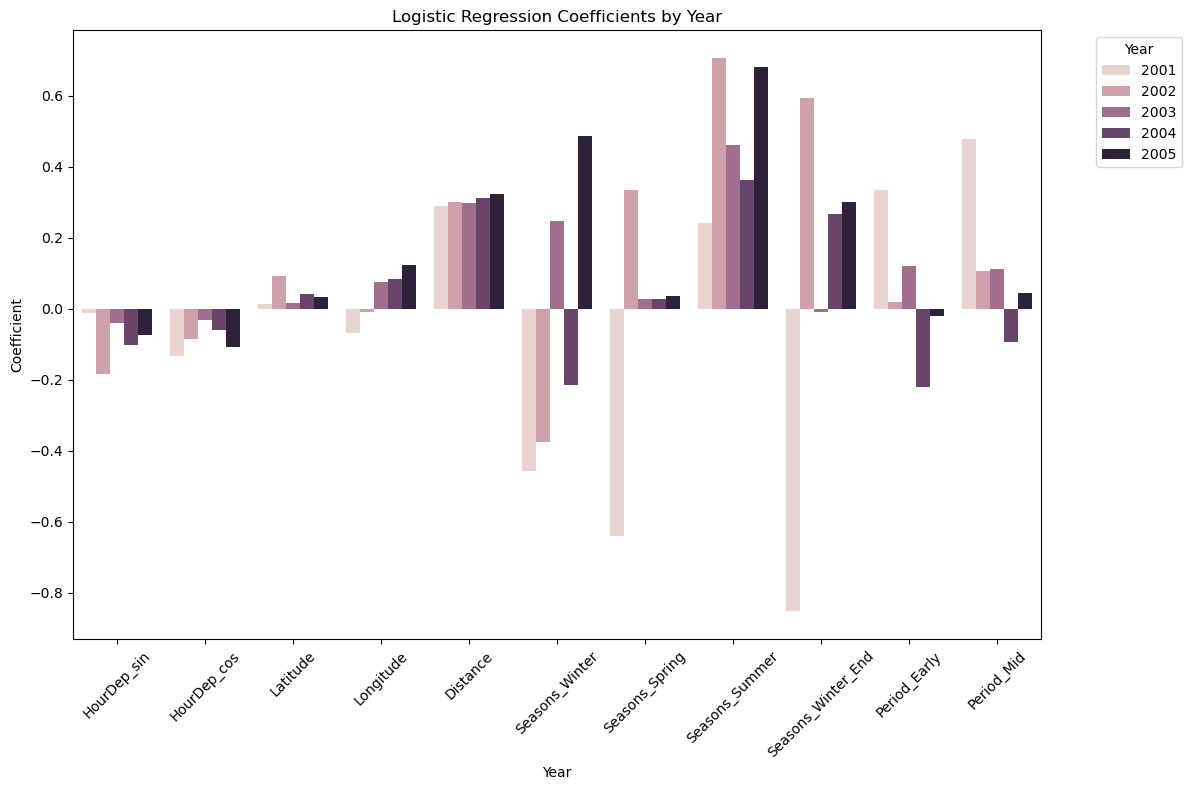

In [51]:
plt.figure(figsize=(12, 8))
sns.barplot(data=all_coefs, x='feature', y='coefficient', hue='year')
plt.title("Logistic Regression Coefficients by Year")
plt.xlabel("Year")
plt.ylabel("Coefficient")
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [52]:
print(all_performance)

   year  accuracy   roc_auc     fbeta  precision    recall
0  2001  0.533616  0.645337  0.611080   0.465309  0.889849
1  2002  0.494150  0.631735  0.594827   0.443776  0.901768
2  2003  0.454066  0.606165  0.591693   0.427500  0.960660
3  2004  0.457170  0.621661  0.582649   0.426276  0.920218
4  2005  0.494904  0.634245  0.593401   0.443809  0.895113


In [53]:
print(all_confusion)

   year     TN      FP     FN      TP
0  2001   4181   10527   1134    9161
1  2002  27295  103417   8988   82510
2  2003  20823  188562   5766  140804
3  2004  36599  238508  15364  177211
4  2005  66038  241462  22577  192673


In [54]:
print(all_coefs)

               feature  coefficient  year
0          HourDep_sin    -0.011992  2001
1          HourDep_cos    -0.134549  2001
2             Latitude     0.011842  2001
3            Longitude    -0.068067  2001
4             Distance     0.288489  2001
5       Seasons_Winter    -0.457064  2001
6       Seasons_Spring    -0.641039  2001
7       Seasons_Summer     0.242083  2001
8   Seasons_Winter_End    -0.853299  2001
9         Period_Early     0.333909  2001
10          Period_Mid     0.478709  2001
11         HourDep_sin    -0.183974  2002
12         HourDep_cos    -0.086100  2002
13            Latitude     0.091001  2002
14           Longitude    -0.010463  2002
15            Distance     0.301301  2002
16      Seasons_Winter    -0.374420  2002
17      Seasons_Spring     0.335028  2002
18      Seasons_Summer     0.706382  2002
19  Seasons_Winter_End     0.594179  2002
20        Period_Early     0.017531  2002
21          Period_Mid     0.105056  2002
22         HourDep_sin    -0.03937

In [102]:
conn.close()